<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#--Creating-the-structure" data-toc-modified-id="--Creating-the-structure-0.1">- Creating the structure</a></span></li><li><span><a href="#--Creating-features" data-toc-modified-id="--Creating-features-0.2">- Creating features</a></span></li><li><span><a href="#--Split-Data" data-toc-modified-id="--Split-Data-0.3">- Split Data</a></span></li><li><span><a href="#--Min-Expected-Error" data-toc-modified-id="--Min-Expected-Error-0.4">- Min Expected Error</a></span></li><li><span><a href="#--XGBoost" data-toc-modified-id="--XGBoost-0.5">- XGBoost</a></span></li></ul></li><li><span><a href="#View-Bruno's-notebook-&quot;new_features&quot;-for-a-analysis-of-new-product-selling" data-toc-modified-id="View-Bruno's-notebook-&quot;new_features&quot;-for-a-analysis-of-new-product-selling-1">View Bruno's notebook "new_features" for a analysis of new product selling</a></span></li></ul></div>

In [1]:
%%javascript
$('#menubar').toggle();

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
infos = pd.read_csv('infos.csv', sep = '|')

In [4]:
items = pd.read_csv('items.csv', sep = '|')

In [5]:
orders = pd.read_csv('orders.csv', sep = '|', parse_dates=['time'])

## - Creating the structure

In [6]:
# We want the 14 dats between June 16 and June 29 to be the week pair -1
print((pd.Series(['2018-06-30 00:00:01']).astype('datetime64[ns]').dt.dayofyear + 1) // 14 - 13)

print((pd.Series(['2018-06-29 00:00:01']).astype('datetime64[ns]').dt.dayofyear + 1) // 14 - 13)

print((pd.Series(['2018-06-16 00:00:01']).astype('datetime64[ns]').dt.dayofyear + 1) // 14 - 13)

print((pd.Series(['2018-06-15 00:00:01']).astype('datetime64[ns]').dt.dayofyear + 1) // 14 - 13)

0    0
dtype: int64
0   -1
dtype: int64
0   -1
dtype: int64
0   -2
dtype: int64


In [7]:
df = orders.copy()

In [8]:
df['weekpair'] = (df.time.dt.dayofyear + 1) // 14 - 13

In [9]:
df.weekpair.max(), df.weekpair.min()

(-1, -13)

In [10]:
npairs = df.weekpair.nunique()

In [11]:
n_items = items['itemID'].nunique()
print('total number of items:', n_items)
print('expected number of instances:', n_items * npairs)

total number of items: 10463
expected number of instances: 136019


In [12]:
mi = pd.MultiIndex.from_product([range(-npairs, 0), items['itemID']], names=['weekpair', 'itemID'])
data_temp = pd.DataFrame(index = mi)

In [13]:
data_temp = data_temp.join(df.groupby(['weekpair', 'itemID'])[['order']].sum(), how = 'left')

In [14]:
data_temp.fillna(0, inplace = True)

In [15]:
data_temp.groupby('itemID').count().min()

order    13
dtype: int64

In [16]:
data_temp

order
weekpair itemID       
-13      1         0.0
         2         0.0
         3         1.0
         4         0.0
         5         2.0
...                ...
-1       10459     0.0
         10460     0.0
         10461     0.0
         10462     0.0
         10463     0.0

[136019 rows x 1 columns]

## - Creating features

In [17]:
data = data_temp.reset_index()

In [18]:
items.head(2)

,Unnamed: 0,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,0,1,0,1,4.38,1,1,1,8.84
1,1,2,0,2,3.00,1,2,1,16.92


In [19]:
# data = pd.merge(data, items[['itemID', 'manufacturer', 'category1', 'category2', 'category3']], on = 'itemID')
data = pd.merge(data, items, on = 'itemID')

In [20]:
data.sort_values('weekpair', inplace = True)

In [21]:
data

,weekpair,itemID,order,Unnamed: 0,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,-13,1,0.0,0,0,1,4.38,1,1,1,8.84
83304,-13,6409,0.0,6408,0,159,0.00,5,32,4,9.59
118534,-13,9119,0.0,9118,202,242,0.00,8,44,8,519.87
17485,-13,1346,0.0,1345,0,35,0.00,1,5,1,28.85
52702,-13,4055,0.0,4054,0,86,0.00,2,8,2,18.79
...,...,...,...,...,...,...,...,...,...,...,...
59565,-1,4582,0.0,4581,0,127,0.00,6,19,3,4.35
76452,-1,5881,0.0,5880,0,159,0.00,5,32,4,7.22
46682,-1,3591,4.0,3590,74,86,0.00,2,8,2,21.66
126372,-1,9721,0.0,9720,195,240,0.00,8,43,8,15.02


In [22]:
def gbagg(data, group_cols, targeted_cols, out_names, function, as_index = False):
  
    X = data.values
    col = {c : i for i, c in enumerate(data.columns)}

    # values that are going to calculated
    new_feat = []
    
    # numbers of the columns
    gcols = [col[c] for c in group_cols]
    tcols = [col[c] for c in targeted_cols]
    
    interval = None
    a = None
    i = 0
    while i < len(X):
        a = X[i, gcols]

        # find the whole interval of this group
        j = i
        while j < len(X):
            if (X[j, gcols] != a).any():
                break
            j += 1
        interval = X[i:j, tcols]

        # apply function on interval, save in new feature
        output = function(interval)
        new_feat.append(output)

        # go to next group
        i = j
    
    idx = data.groupby(group_cols).size().index # this is actually fast...
    out_df = pd.DataFrame(new_feat, columns = out_names, index = idx)
        
    if not as_index:
        out_df.reset_index(inplace = True)
        
    return out_df

In [23]:
def gbtransf(data, group_cols, targeted_cols, out_names, function, params = dict()):
  
    X = data.values
    col = {c : i for i, c in enumerate(data.columns)}

    # values that are going to calculated
    new_feat = np.zeros((len(data), len(out_names)))
    
    # numbers of the columns
    gcols = [col[c] for c in group_cols]
    tcols = [col[c] for c in targeted_cols]
    
    interval = None
    a = None
    i = 0
    while i < len(X):
        a = X[i, gcols]

        # find the whole interval of this group
        j = i
        while j < len(X):
            if (X[j, gcols] != a).any():
                break
            j += 1
        interval = X[i:j, tcols]

        # apply function on interval, save in new feature
        output = function(interval, **params)
        new_feat[i:j] = output

        # go to next group
        i = j
    
    out_df = pd.DataFrame(new_feat, columns = out_names, index = data.index)
        
    return out_df

In [24]:
data.sort_values(['itemID', 'weekpair'], inplace = True)

In [25]:
# gbtransf(data, ['itemID', 'weekpair'], ['order'], ['out'], lambda x : np.ones_like(x))

In [26]:
def shift_and_2n_window(x, ws):
#     out = pd.DataFrame(x)
#     out = out.shift()
#     out = out.rolling(2 ** n).mean()

    shifted = np.zeros_like(x) # output
    shifted[1:] = x[:-1] # shift
    out = np.zeros_like(x, dtype = float)
    
    # rolling mean
    total = shifted[:ws].sum()
    out[ws - 1] = total / ws
    for i in range(ws, len(out)):
        total = total - shifted[i - ws] + shifted[i]
        out[i] = total / ws
    out[:ws] = np.NaN # maybe ws -1 should be NaN as well for receiving one NaN value when ws > 1
    # out[0] = np.NaN # this is always NaN for a shift of 1
    return out

In [27]:
shift_and_2n_window(np.array([1 , 2, 3, 4, 5, 6]), 2 ** 1)

array([nan, nan, 1.5, 2.5, 3.5, 4.5])

In [28]:
features = [('itemID', 'item')]

In [29]:
for f, name in features:
    print(f)
    new_feature_block = pd.DataFrame()
    for n in range(3):
        new_f = gbtransf(data, ['itemID'], ['order'], ['out'], shift_and_2n_window, {'ws' : 2 ** n})
        new_feature_block['%s_%d' % (name, 2 ** n)] = new_f['out']
#     data = pd.merge(data, new_feature_block.reset_index(), on = [f, 'weekpair'])
    data = pd.concat([data, new_feature_block], axis =  1)

itemID


In [30]:
data.count() # the larger the window, more NaN are expected

weekpair                  136019
itemID                    136019
order                     136019
Unnamed: 0                136019
brand                     136019
manufacturer              136019
customerRating            136019
category1                 136019
category2                 136019
category3                 136019
recommendedRetailPrice    136019
item_1                    125556
item_2                    115093
item_4                     94167
dtype: int64

In [31]:
def dist2firstvalue(x):
    out = np.zeros_like(x, dtype = float)
    first = np.NaN
    for i in range(len(x)):
        out[i] = first
        if x[i] != 0:
            first = i
            break
    if i == len(x) - 1:
        return out
    for j in range(int(first), len(x)):
        out[j] = j - first
        
    return out

In [32]:
# dist2firstvalue(np.array([0 , 0, 3, 0, 5, 6]))
dist2firstvalue(np.array([0 , 0, 0, 0]))

array([nan, nan, nan, nan])

In [33]:
def dist2lastpeak(x):
    out = np.zeros_like(x, dtype = float)
    peak = np.NaN
    peak_val = 0
    for i in range(0, len(x)):
        out[i] = i - peak
        if x[i] > peak_val:
            peak = i
            peak_val = x[i]
        
    return out

In [34]:
dist2lastpeak(np.array([0 , 0, 3, 0, 5, 6]))

array([nan, nan, nan,  1.,  2.,  1.])

In [35]:
data.sort_values(['itemID', 'weekpair'], inplace = True)

In [36]:
# data['dist2firstvalue'] = gbtransf(data, ['itemID'], ['order'], ['out'], dist2firstvalue)['out']
data['dist2lastpeak'] = gbtransf(data, ['itemID'], ['order'], ['out'], dist2lastpeak)['out']

In [37]:
data.fillna(-999, inplace=True)

In [38]:
# checking if we got what we wanted
data.query('itemID == 1')

,weekpair,itemID,order,Unnamed: 0,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,item_1,item_2,item_4,dist2lastpeak
0,-13,1,0.0,0,0,1,4.38,1,1,1,8.84,-999.0,-999.0,-999.00,-999.0
1,-12,1,2.0,0,0,1,4.38,1,1,1,8.84,0.0,-999.0,-999.00,-999.0
2,-11,1,313.0,0,0,1,4.38,1,1,1,8.84,2.0,1.0,-999.00,1.0
3,-10,1,35.0,0,0,1,4.38,1,1,1,8.84,313.0,157.5,-999.00,1.0
4,-9,1,3.0,0,0,1,4.38,1,1,1,8.84,35.0,174.0,87.50,2.0
5,-8,1,1.0,0,0,1,4.38,1,1,1,8.84,3.0,19.0,88.25,3.0
6,-7,1,1.0,0,0,1,4.38,1,1,1,8.84,1.0,2.0,88.00,4.0
7,-6,1,2.0,0,0,1,4.38,1,1,1,8.84,1.0,1.0,10.00,5.0
8,-5,1,299.0,0,0,1,4.38,1,1,1,8.84,2.0,1.5,1.75,6.0
9,-4,1,3.0,0,0,1,4.38,1,1,1,8.84,299.0,150.5,75.75,7.0


In [39]:
counts = data.groupby('itemID')['order'].apply(lambda x : (x > 0).sum())

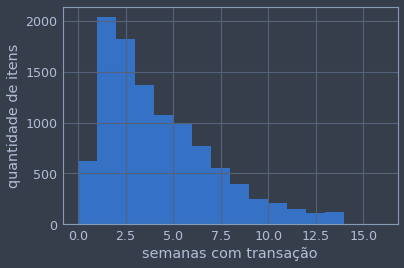

In [40]:
plt.hist(counts, bins = range(17))
plt.ylabel('quantidade de itens')
plt.xlabel('semanas com transação')
plt.show()

In [41]:
data.head()

,weekpair,itemID,order,Unnamed: 0,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,item_1,item_2,item_4,dist2lastpeak
0,-13,1,0.0,0,0,1,4.38,1,1,1,8.84,-999.0,-999.0,-999.0,-999.0
1,-12,1,2.0,0,0,1,4.38,1,1,1,8.84,0.0,-999.0,-999.0,-999.0
2,-11,1,313.0,0,0,1,4.38,1,1,1,8.84,2.0,1.0,-999.0,1.0
3,-10,1,35.0,0,0,1,4.38,1,1,1,8.84,313.0,157.5,-999.0,1.0
4,-9,1,3.0,0,0,1,4.38,1,1,1,8.84,35.0,174.0,87.5,2.0


##  - Split Data

In [42]:
filtered_data = data

In [43]:
sub_week = -1
train = filtered_data.query('-13 <= weekpair <= (@sub_week - 2)').reset_index(drop = True)
full_train = filtered_data.query('-13 <= weekpair <= (@sub_week - 1)').reset_index(drop = True)
val = filtered_data.query('weekpair == (@sub_week - 1)').reset_index(drop = True)
sub = filtered_data.query('weekpair == (@sub_week)').reset_index(drop = True)

In [44]:
len(train), len(val), len(sub)

(115093, 10463, 10463)

In [45]:
weights = infos.set_index('itemID')['simulationPrice'].to_dict()

In [46]:
train.columns

Index(['weekpair', 'itemID', 'order', 'Unnamed: 0', 'brand', 'manufacturer',
       'customerRating', 'category1', 'category2', 'category3',
       'recommendedRetailPrice', 'item_1', 'item_2', 'item_4',
       'dist2lastpeak'],
      dtype='object')

In [47]:
y_train = train.pop('order').values
y_full_train = full_train.pop('order').values
y_val = val.pop('order').values
y_sub = sub.pop('order').values

X_train = train.values
X_full_train = full_train.values
X_val = val.values
X_sub = sub.values

w_train = train['itemID'].map(weights)
w_full_train = full_train['itemID'].map(weights)
w_val = val['itemID'].map(weights)
w_sub = sub['itemID'].map(weights)

<hr>

## - Min Expected Error

In [48]:
def evaluate(prediction, target, simulationPrice):
    return np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulationPrice)

In [49]:
# max expected rmse
from sklearn.metrics import mean_squared_error as mse
# pred = data.loc[1:12].groupby('itemID')['order'].mean().sort_index()
# target_week = data.loc[13:, 'order'].reset_index(level = 0, drop = True).sort_index()
# mse(target_week, pred) ** .5

<hr>

## - XGBoost

In [50]:
import xgboost as xgb

In [51]:
xgb.__version__

'1.1.1'

In [52]:
# custom objective

def gradient(prediction, dtrain):
    y = dtrain.get_label()
#     prediction.astype(int)
#     prediction = np.minimum(prediction.astype(int), 1)
    return -2 * (prediction - np.maximum(prediction - y, 0) * 1.6) * (1 - (prediction > y) * 1.6)

def hessian(prediction, dtrain):
    y = dtrain.get_label()
#     prediction.prediction(int)
#     prediction = np.minimum(prediction.astype(int), 1)
    return -2 * (1 - (prediction > y) * 1.6) ** 2

def objective(prediction, dtrain):
    w = dtrain.get_weight()
    grad = gradient(prediction, dtrain) * w
    hess = hessian(prediction, dtrain) * w
    return grad, hess

In [53]:
# custom feval

def feval(prediction, dtrain):
    prediction = prediction.astype(int)
#     predt = np.minimum(predt.astype(int), 1)
    target = dtrain.get_label()
    simulationPrice = dtrain.get_weight()
    return 'feval', np.sum((prediction - np.maximum(prediction - target, 0) * 1.6)  * simulationPrice)

In [54]:
dtrain = xgb.DMatrix(X_train, y_train, w_train, missing = -999)
dfulltrain = xgb.DMatrix(X_full_train, y_full_train, w_full_train, missing = -999)
dval = xgb.DMatrix(X_val, y_val, w_val, missing = -999)
dsub = xgb.DMatrix(X_sub, y_sub, w_sub, missing = -999)
# specify parameters via map
param = {
    'max_depth':10,
    'eta':0.005,
    'objective':'reg:squarederror',
    'disable_default_eval_metric': 1,
#     'tree_method' : 'gpu_hist',
}
num_round = 100
bst = xgb.train(param, dtrain,
                num_round,
                early_stopping_rounds = 30,
                evals = [(dtrain, 'train'), (dval, 'val')],
#                 obj = objective,
                feval = feval,
                maximize = True,
                )

[0]	train-feval:58239.22597	val-feval:3573.73400
Multiple eval metrics have been passed: 'val-feval' will be used for early stopping.

Will train until val-feval hasn't improved in 30 rounds.
[1]	train-feval:108766.18396	val-feval:7980.53401
[2]	train-feval:185213.55595	val-feval:16831.43200
[3]	train-feval:224974.52999	val-feval:22118.80002
[4]	train-feval:255510.01802	val-feval:24984.45801
[5]	train-feval:281361.16425	val-feval:27722.19800
[6]	train-feval:336754.62016	val-feval:35915.19604
[7]	train-feval:384313.85011	val-feval:38565.18206
[8]	train-feval:386072.24178	val-feval:36730.59207
[9]	train-feval:403826.91759	val-feval:35535.08408
[10]	train-feval:437518.90573	val-feval:34375.66207
[11]	train-feval:464291.28149	val-feval:34529.54809
[12]	train-feval:500761.15139	val-feval:35165.36809
[13]	train-feval:531483.52338	val-feval:35609.04410
[14]	train-feval:577188.35950	val-feval:37392.50613
[15]	train-feval:614377.56552	val-feval:38721.12212
[16]	train-feval:644662.08923	val-feva

In [55]:
prediction = bst.predict(dsub, ntree_limit=bst.best_ntree_limit).astype(int)
evaluate(prediction, y_sub, w_sub)

75038.45999999996

# View Bruno's notebook "new_features" for a analysis of new product selling


In [57]:
# Weekpair is negative, so this works:
first_fortnight_item = df.sort_values("weekpair").groupby(["itemID"])["weekpair"].first()
first_fortnight_item.head()

itemID
1   -12
2    -9
3   -13
4   -12
5   -13
Name: weekpair, dtype: int64

In [58]:
temp = df.query("weekpair == -2")
new_items = first_fortnight_item[first_fortnight_item == -2].index
new_items_counts = temp.loc[temp["itemID"].isin(new_items)]
new_items_counts = new_items_counts.groupby("itemID")["order"].sum()
new_items_counts.describe()

count     727.000000
mean      135.397524
std       183.151453
min         1.000000
25%         5.500000
50%        86.000000
75%       202.000000
max      1650.000000
Name: order, dtype: float64

In [59]:
new_items_value = 10  # The mode seems too high, so go with 10...
idx = sub["itemID"].isin(first_fortnight_item[first_fortnight_item == -1].index)
prediction[idx] = new_items_value
evaluate(prediction, y_sub, w_sub)

447378.522

In [60]:
# retrain!

In [61]:
bst_sub = xgb.train(param, dfulltrain,
    num_boost_round = bst.best_ntree_limit, early_stopping_rounds = 5,
    #                 obj = objective,
    feval = feval, maximize = True,
    evals = [(dfulltrain, 'ftrain')],
    verbose_eval = False,
)

In [62]:
prediction = bst_sub.predict(dsub, ntree_limit=bst_sub.best_ntree_limit).astype(int)

new_items_value = 10  # The mode seems too high, so go with 10...
idx = sub["itemID"].isin(first_fortnight_item[first_fortnight_item == -1].index)
prediction[idx] = new_items_value
evaluate(prediction, y_sub, w_sub)

438193.05399999995